# Tree-based Models

Authored by [JumpThanawut](https://github.com/orgs/Datatouille/people/JumpThanawut); Edited by [cstorm125](https://github.com/cstorm125/)

Tree-based models are strong baselines when doing any type of supervised learning. They come with handy characteristics such as not requiring standardizing your features, handling categorical variables and powerful ensembling. It is always a decent thing to start with tree-based models as baselines. This notebook will get you started on training a default-parameter decision tree, random forest and gradient boosted tree.

In [ ]:
# #uncomment if you are running from google colab
# !wget https://github.com/Datatouille/snaplogic_snap_recommendation/archive/master.zip; unzip master
# !mv snaplogic_snap_recommendation-master/* .
# !ls

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from utils import *

## Load Data

In [2]:
train_df = pd.read_csv("train_df.csv")
valid_df = pd.read_csv("valid_df.csv")
submit_df = pd.read_csv("submit_df.csv")
all_df = pd.concat([train_df,valid_df,submit_df],0).reset_index(drop=True)
train_df.shape, valid_df.shape, submit_df.shape

((103112, 9), (14731, 9), (29461, 9))

In [3]:
train_df.head()

,date,org,prev_snap_1,prev_snap_2,prev_snap_3,prev_snap_4,project,target_snap,user
0,2014-12-05,4,0,0,0,0,145,195,59
1,2014-12-05,4,178,195,0,0,145,240,59
2,2014-12-05,4,195,0,0,0,145,178,59
3,2015-02-10,4,240,223,88,0,414,195,59
4,2015-02-10,4,88,0,0,0,414,223,59


In [4]:
all_df.describe()

,org,prev_snap_1,prev_snap_2,prev_snap_3,prev_snap_4,project,user
count,147304.000000,147304.000000,147304.000000,147304.000000,147304.000000,147304.000000,147304.000000
mean,2.208175,197.588918,142.951434,95.698644,57.561933,198.635292,109.667599
std,0.653883,145.142200,153.572771,143.504422,120.459634,94.953073,50.189249
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2.000000,27.000000,0.000000,0.000000,0.000000,170.000000,82.000000
50%,2.000000,240.000000,88.000000,0.000000,0.000000,170.000000,90.000000
75%,2.000000,279.000000,240.000000,224.000000,0.000000,170.000000,140.000000
max,4.000000,485.000000,485.000000,485.000000,485.000000,506.000000,217.000000


## Feature Engineering

All our features are discrete so we need to perform one-hot encoding before serving them to the model.

In [5]:
#one hot encode the features
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(categories=[np.arange(1,5), \
                                np.arange(486),np.arange(486),np.arange(486),np.arange(486),\
                                np.arange(1,507),np.arange(1,218)])

feature_cols = ['org','prev_snap_1','prev_snap_2','prev_snap_3','prev_snap_4','project','user']
train_x = train_df[feature_cols].values
enc_fit = enc.fit(train_x)
train_x = enc_fit.transform(train_x)
train_y = train_df["target_snap"].values.astype(str)
valid_x = enc_fit.transform(valid_df[feature_cols].values)
valid_y = valid_df["target_snap"].values.astype(str)
train_x.shape, train_y.shape, valid_x.shape, valid_y.shape

((103112, 2671), (103112,), (14731, 2671), (14731,))

## Models

### Decision Tree

In [7]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf = clf.fit(train_x, train_y)
print(f'Accuracy: {clf.score(valid_x,valid_y)}') 
print(f'Top-5 Accuracy: {score_topk(clf,valid_x,valid_y,k=5)}')

Accuracy: 0.5001018260810536
Top-5 Accuracy: 0.7468603625008485


### Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(train_x, train_y)
print(f'Accuracy: {clf.score(valid_x,valid_y)}') 
print(f'Top-5 Accuracy: {score_topk(clf,valid_x,valid_y,k=5)}')

Accuracy: 0.48808634851673344
Top-5 Accuracy: 0.7774760708709524


### Gradient Boosted Tree

In [47]:
from lightgbm.sklearn import LGBMClassifier
clf = LGBMClassifier(boosting_type='gbdt', num_leaves=31, n_estimators=10,
                objective='ovr', num_class=486)
clf = clf.fit(train_x, train_y)
probs = clf.predict_proba(valid_x)

In [49]:
print(f'Accuracy: {clf.score(valid_x,valid_y)}')
print(f'Top-5 Accuracy: {score_topk(probs,valid_y,k=5)}')

Accuracy: 0.2043310026474781
Top-5 Accuracy: 0.7085737560247098


## Evaluation

With 486 target classes, it is almost impossible to diagnose how well your model performs by looking at confusion matrix like you would normally do. Using the decision tree and random forest classifier, we provide some ideas for model evaulation.

In [62]:
clf_tree = DecisionTreeClassifier()
clf_tree = clf_tree.fit(train_x, train_y)
print(f'Accuracy: {clf_tree.score(valid_x,valid_y)}') 
print(f'Top-5 Accuracy: {score_topk(clf_tree,valid_x,valid_y,k=5)}')

Accuracy: 0.5017310433779105
Top-5 Accuracy: 0.74652094223067


In [63]:
clf_forest = RandomForestClassifier(n_estimators=10)
clf_forest = clf_forest.fit(train_x, train_y)
print(f'Accuracy: {clf_forest.score(valid_x,valid_y)}') 
print(f'Top-5 Accuracy: {score_topk(clf_forest,valid_x,valid_y,k=5)}')

Accuracy: 0.4935849568936257
Top-5 Accuracy: 0.7717059262779173


We can see that while decision tree has higher validation accuracy, it has lower top-5 validation accuracy. In order to see how top-k number of suggestions play a part in model performance, we plot the accuracies of each model at each k. You can see that according to the top-k-vs-accuracy plot, random forest outperforms decision tree in all cases excpet when k=1.

In [64]:
#accurayc curve
accs_tree = []
accs_forest = []
for i in tqdm_notebook(range(1,101)):
    accs_tree.append(score_topk(clf_tree,valid_x,valid_y,k=i))
    accs_forest.append(score_topk(clf_forest,valid_x,valid_y,k=i))

Area Under Accuracy Curve; Tree: 87.6165229787523, Forest: 89.82519856085804


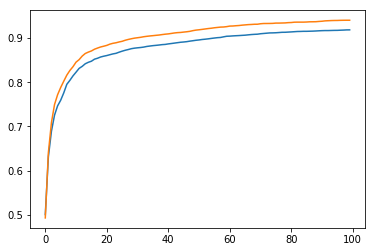

In [68]:
#zoom in on top 10
print(f'Area Under top-k-vs-accuracy line; Tree: {sum(accs_tree)}, Forest: {sum(accs_forest)}')
plt.plot(accs_tree)
plt.plot(accs_forest)

Area Under Accuracy Curve; Tree: 7.24193876858326, Forest: 7.4318104677211325


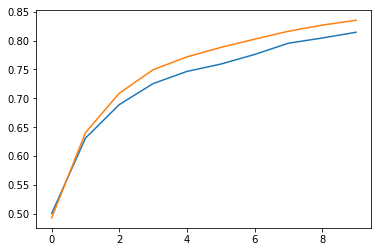

In [69]:
print(f'Area top-k-vs-accuracy line; Tree: {sum(accs_tree[:10])}, Forest: {sum(accs_forest[:10])}')
plt.plot(accs_tree[:10])
plt.plot(accs_forest[:10])